# Introduction: An object-oriented interface to SSRL's SPEC data

<b>EC_Xray</b> is a user-friendly and powerful object-oriented interface to diffraction data output by SPEC, the data-acquisition software at SSRL. 

This ipython notebook provides a tutorial on how to use <b>EC_Xray</b> for XRD spectra (tth scans). See the other python notebook(s) for XRD timescans and combining synchrotron data with electrochemistry data.

The data used as an example here was taken at SSRL Beamline 2-1

The most up-to-date version of the code will always be at https://github.com/ScottSoren/.

For collaboration or questions, contact Soren Scott at scott@fysik.dtu.dk

# Setting up

EC_Xray should be added to your python path to import the classes and functions below.

(The first three lines are just to configure the figures output for the jupyter notebook and pdf)

In [1]:
%matplotlib inline                 
import matplotlib as mpl 
mpl.rcParams['figure.dpi']= 200 

import numpy as np
import matplotlib.pyplot as plt

from EC_Xray import Pilatus         # class for pilatus images 
from EC_Xray import ScanImages      # class for scans of pilatus images
from EC_Xray import load_from_file  # function for loading .csv data

(<b>EC_Xray</b> will soon have a function for getting calibration information from a calibration scan, but for now we use the information calculated from an older script. The calibration is stored as a dictionary in the cell below)

In [2]:
calibration = {'direct_beam_x': 277,
               'direct_beam_y': 91,
               'Sample_Detector_distance_pixels': 4085.27,
               'Sample_Detector_distance_mm': 702.666}

# The EC_Xray.Pilatus object

The Pilatus handles the images output by 2-D diffraction detectors

## Showing an image
In this first cell, we import a pilatus image and display it. All that is needed to initiate a pilatus image is the file name (with path and extension) of the image file. <b>EC_Xray.Pilatus.show_image()</b> shows the image. The default colormap is inferno.

This images is the first in a tth scan.

loading Pilatus object for ./data/Pilatus/tth_scan_0000.raw
Reading RAW file here...


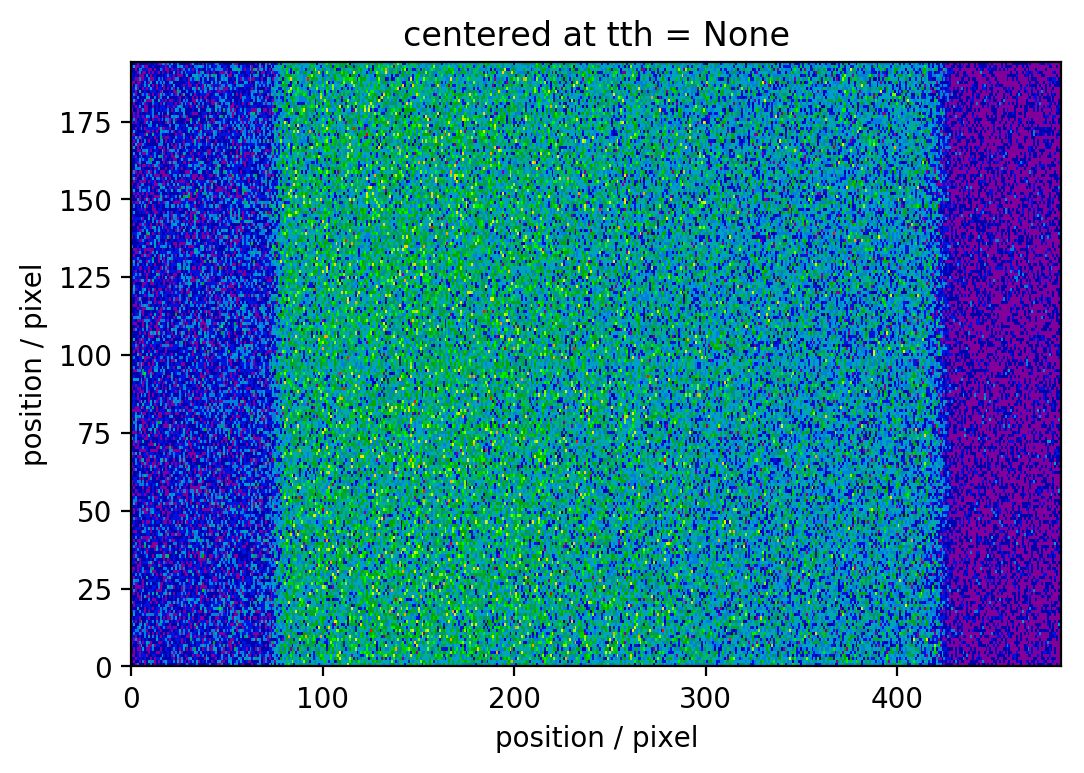

In [3]:
image = Pilatus('./data/Pilatus/tth_scan_0000.raw') 
image.show_image(colormap='spectral'); 

## Hiding pixels behind slits

Note that in the above image, the axes are in pixels. Also, there are dark spots on the sides where the detector is behind slits. Those can be masked away by <b>EC_Xray.Pilatus.apply_slits()</b>. After that, the image is shown with the slits cut out by difault, but the axis refers to the original pixel number. The y direction is shown as horizontal in the images. 

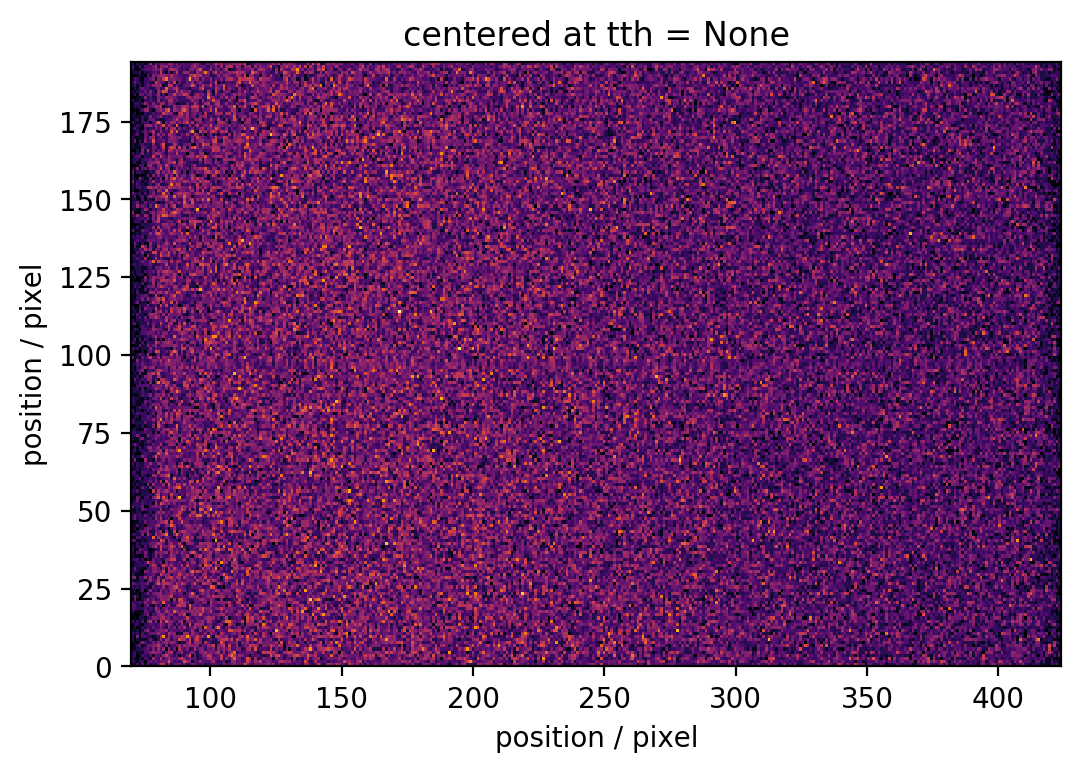

In [4]:
image.apply_slits(yslits=[70, 425]) # slit positions, in pixels
image.show_image(); # colormap is inferno (default)

## Image calibration

We can also calibrate an image, so that the axes are in mm rather than pixel, with the direct-beam pixel at 0,0. This is done in the next cell for a different image, from later in the tth scan:

loading Pilatus object for ./data/Pilatus/tth_scan_0060.raw
Reading RAW file here...


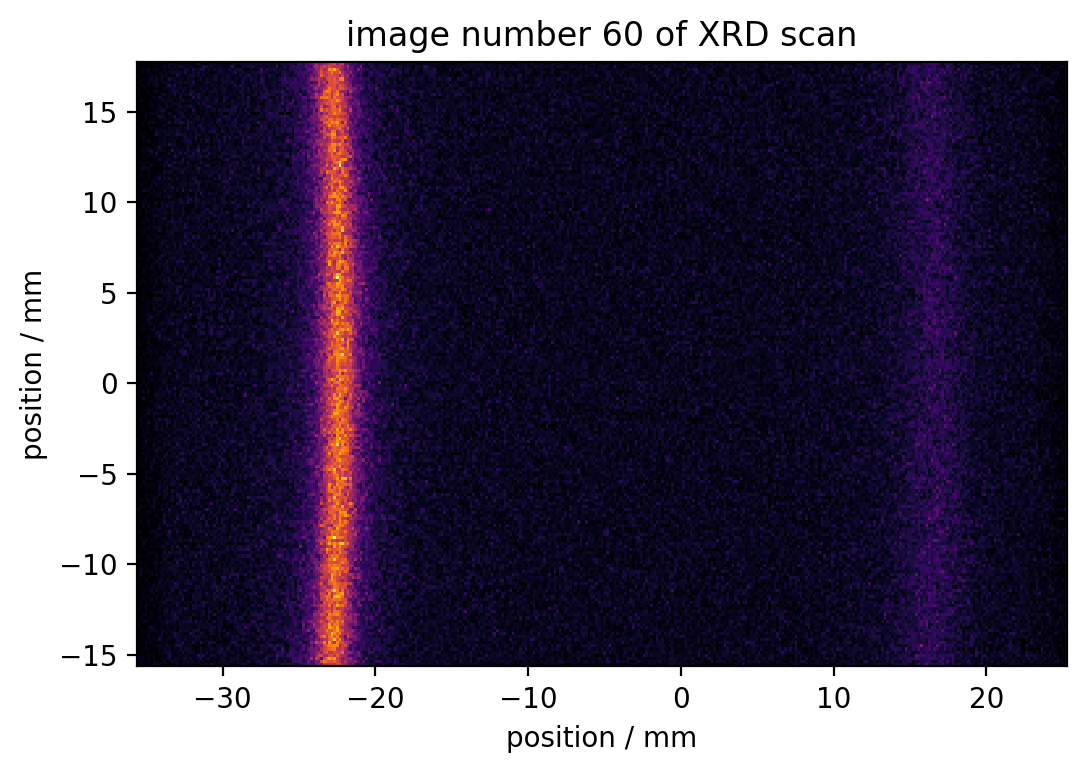

In [5]:
image_2 = Pilatus('./data/Pilatus/tth_scan_0060.raw', 
                  yslits = [70, 425], 
                  calibration = calibration, 
                  )
ax = image_2.show_image()
ax.set_title('image number 60 of XRD scan');

Many images in a tth scan makes up a tth spectrum. 

# The SPEC .csv data
SPEC automatically generates an XRD spectrum using regions of integration (ROI) saved in a .csv file. EC_Xray can load this file into a python dictionary with column headers as keys, as shown here:



function 'load_from_file' at your service!



function 'import_text' at your service!

directory: ./data
importing data from tth_scan.csv
Was able to readlines() with encoding utf8

function 'import_text' finished!




function 'text_to_data' at your service!

Data starting on line 1

timestamp_to_unix_time' didn't receive a string. Returning the argument.

function 'text_to_data' finished!


Couldn't get creation time! Returing modified time.
In linux. Using os.stat('./data/tth_scan.csv').st_mtime as tstamp.

function 'load_from_file' finished!




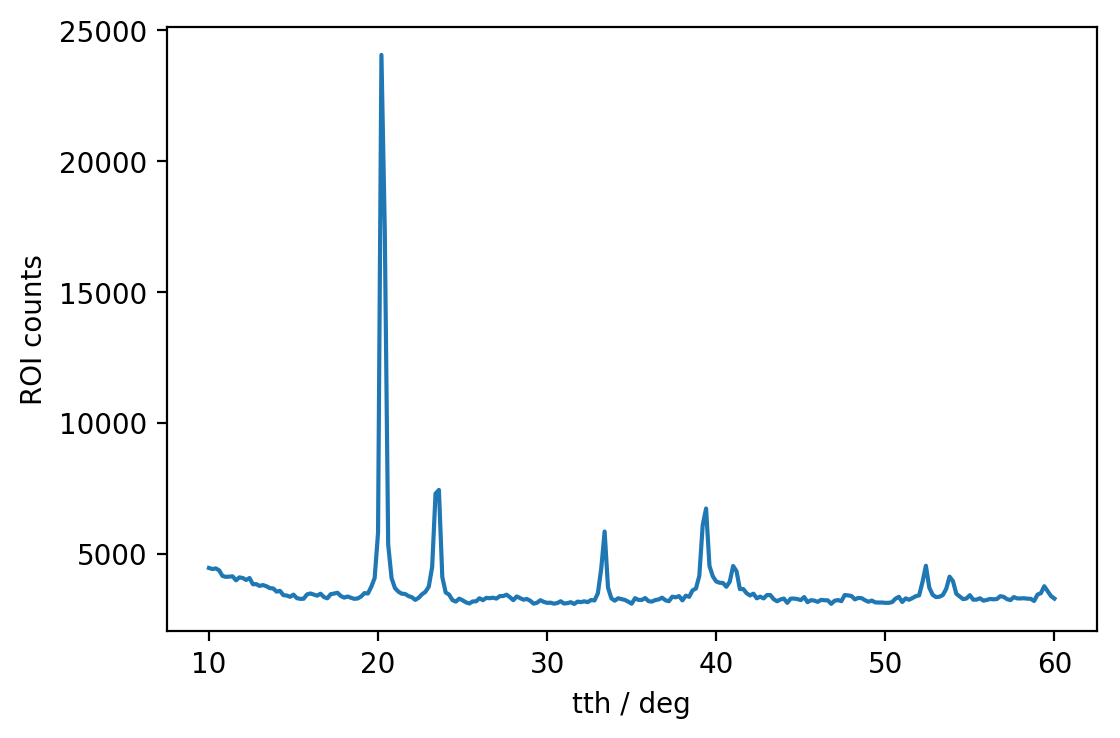

In [6]:
csv_data = load_from_file('./data/tth_scan.csv', data_type='SPEC')
fig, ax = plt.subplots()
ax.plot(csv_data['TwoTheta'], csv_data['pd6'])
ax.set_xlabel('tth / deg');
ax.set_ylabel('ROI counts');

This is of course low-resolution and poor signal-to-noise, as only a small portion of the information in the images is used, and it doesn't take into account the curvature of the iso-tth rings. To get a better spectrum, we need to add up all the images appropriately. 

# The EC_Xray.ScanImages object

The <b>EC_Xray.ScanImages</b> class is designed to do this. It uses both the image data and the csv data. It is initiated like this:

In [7]:
scan = ScanImages(csvfile = './data/tth_scan.csv',
                  pilatusfilebase = './data/Pilatus/tth_scan',
                  calibration = calibration,
                  yslits=[70, 425],
                  scan_type='tth')

Loading Scan: directory = ./data,
	name = tth_scan


function 'load_from_file' at your service!



function 'import_text' at your service!

directory: ./data
importing data from tth_scan.csv
Was able to readlines() with encoding utf8

function 'import_text' finished!




function 'text_to_data' at your service!

Data starting on line 1

timestamp_to_unix_time' didn't receive a string. Returning the argument.

function 'text_to_data' finished!


Couldn't get creation time! Returing modified time.
In linux. Using os.stat('./data/tth_scan.csv').st_mtime as tstamp.

function 'load_from_file' finished!




function 'get_images' at your service!

982 items in ./data/Pilatus
 of which 251 are image files including 'tth_scan'

function 'get_images' finished!


ScanImages object with name tth_scan imported!




 
Indexing the ScanImages object returns the corresponding <b>EC_Xray.Pilatus object</b>, identical to the one above. The only difference is that now it knows the tth value of the direct-beam pixel, since this is read from the .csv file.

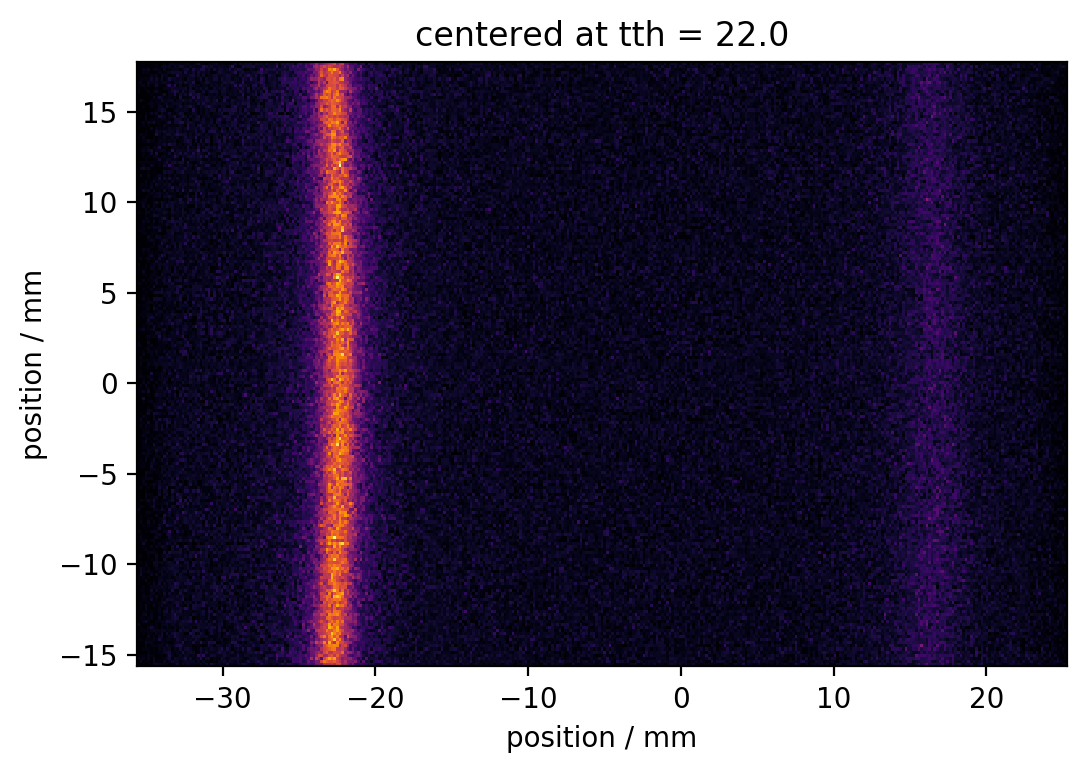

In [8]:
image_3 = scan[60]
image_3.show_image();

This is enough geometrical information to calculate the tth value for each pixel in the image, shown below. 

# The local tth spectrum

Calculating the tth spectrum for an object of the Pilatus class is done through a coordinate tranformation, storing a map of three spherical coordinates for each pixel.

To calculate the tth spectrum of the image, the code groups pixels in the same tth interval and either sums or averages them. This is done via the <b>EC_Xray.Pilatus.tth_spectrum()</b> or <b>EC_Xray.Pilatus.plot_spectrum()</b>

The math for these steps is the same as in previous python scripts from SSRL, but it is fully vectorized here, and thus much faster.

-- image_3.map_spherical.shape = (195, 487, 3)
calculating spectrum for tth_scan_0060.raw


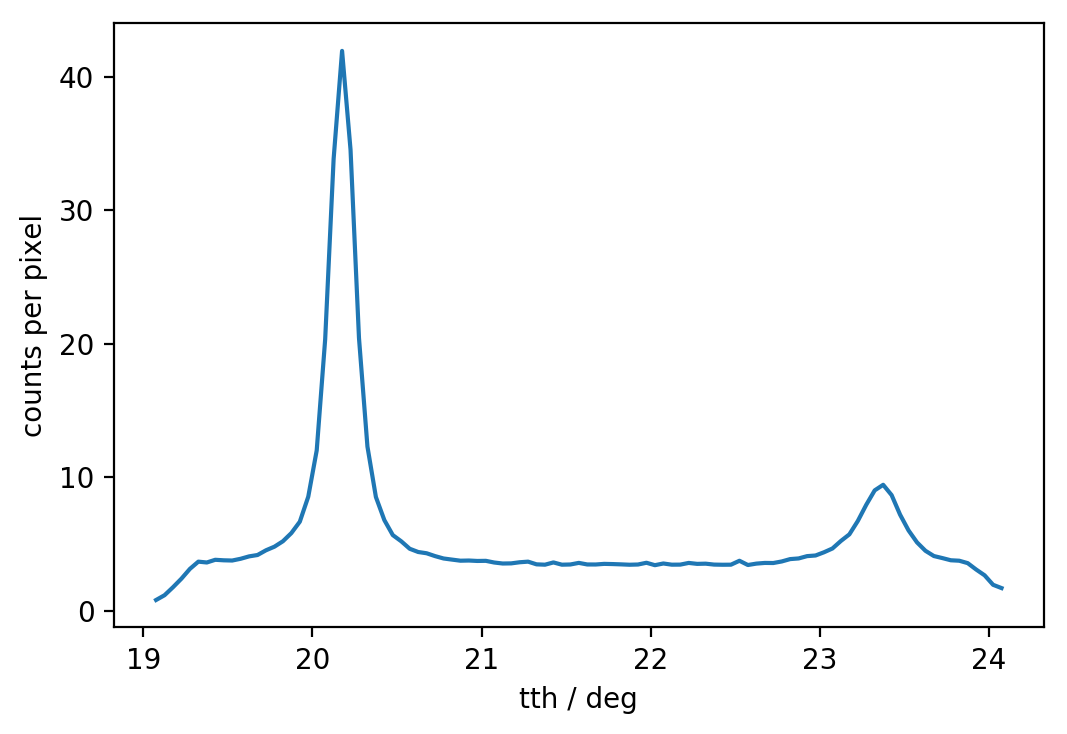

In [9]:
image_3.get_map_sphere();
print('-- image_3.map_spherical.shape = ' + str(image_3.map_sphere.shape))
image_3.plot_spectrum(stepsize=0.05,    # tth intervals width
                      method='average', # average pixels in same interval
                      );

# The global tth spectrum
The overall tth spectrum is just the sum or average of the tth spectra from the individual images. This is calculated with <b>EC_Xray.ScanImages.get_combined_spectrum()</b>. The later returns an axis handle to fine-tune the plot
The coordinate maps for each image takes up a lot of memory, so these should be deleted with <b>EC_Xray.ScanImages.slim()</b>, especially if, for example, there's a loop in your script to calculate spectra from multiple scans.

The time taken to calculate the spectrum, usually on the order of 5 - 10 seconds on a laptop, is printed in the function's output.



function 'get_combined_spectrum' at your service!

t = 0
calculating tth spectrum for each of 251 images, storing in Pilatus objects, and adding them all up.
Counts per tth interval calculated locally and globally. 
Converted to global tth spectrum and stored in ScanImages oject.
t = 7.041795253753662 seconds.

function 'get_combined_spectrum' finished!




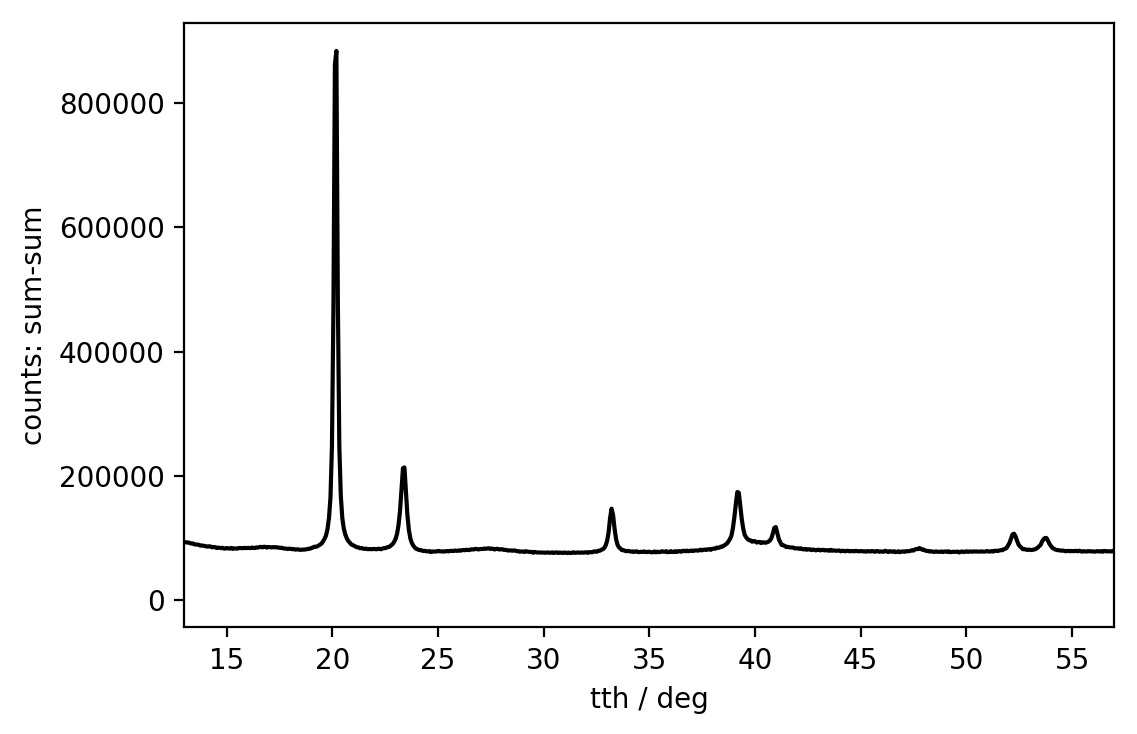

In [10]:
scan.get_combined_spectrum(stepsize = 0.07,  # width of tth bins
                           method = 'sum',   # add pixels in each image
                           scan_method = 'sum', # add image spectra
                          )
scan.slim() #remove coordinate maps from Pilatus objects to save memory
ax = scan.plot_spectrum() 
ax.set_xlim([13, 57]);

## Tuning the global spectrum calculation

Playing around with the <b>stepsize</b>, <b>method</b>, and <b>scan_method</b>, can tune your spectrum. The stepsize is the width of the tth interval. 

* Smaller stepsize gives higher data point density but an excessively small stepsize lowers signal-to-noise ratio. 

* If method and scan_method are both set to <b>'sum'</b>, as above, the spectrum can be interpreted as total counts per tth interval. 

* If both are set to <b>'average'</b>, then the spectrum should be interpreted as counts per pixel, a more intrinsic parameter. 

Sum and average are compared below.

## Cutoff aberation

Here, two normalized spectra are compared in a small region of tth. The black one (calculated in the cell above) is based on counts per tth interval. The green one, calculated here, is counts per pixel. Unfortunately, the counts per pixel spectrum has an aberation with a periodicity equal to the tth step. Fortunately, this can be corrected for by the background subtraction algorithm described below.



function 'get_combined_spectrum' at your service!

t = 0
calculating tth spectrum for each of 251 images, storing in Pilatus objects, and adding them all up.
Counts per tth interval calculated locally and globally. 
Converted to global tth spectrum and stored in ScanImages oject.
t = 4.461972713470459 seconds.

function 'get_combined_spectrum' finished!




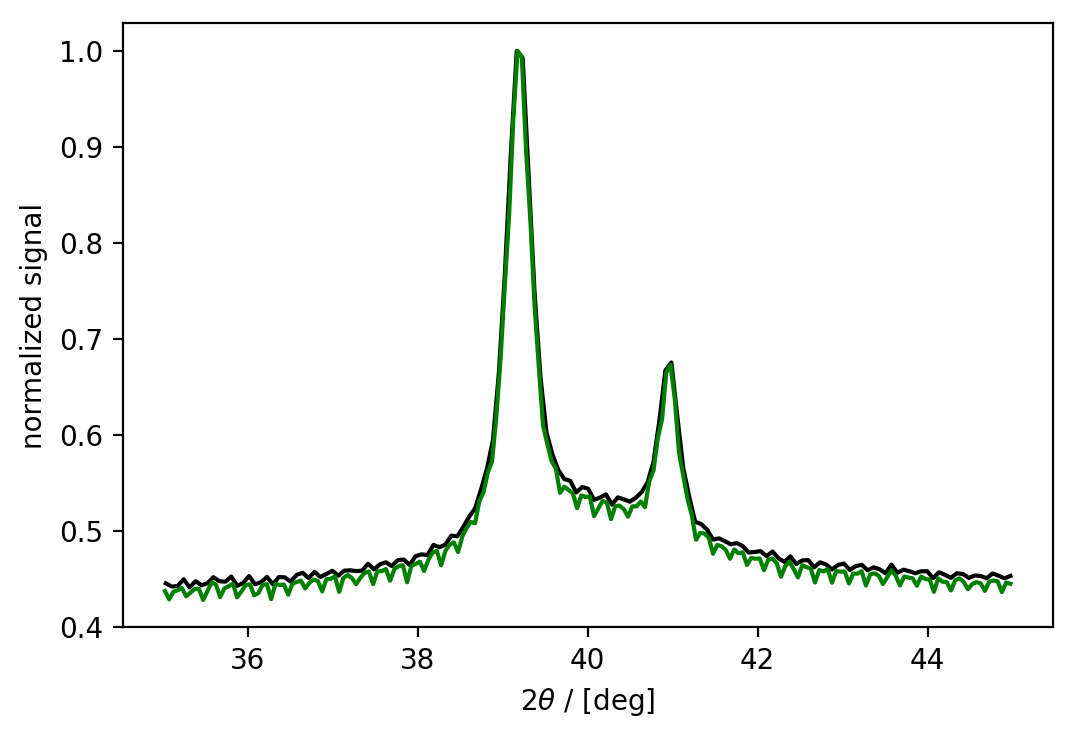

In [11]:
tth1, counts1 = scan.spectrum   # no re-calculation
mask1 = np.logical_and(35<tth1, tth1<45)  # for selecting a range
fig, ax = plt.subplots()           
ax.plot(tth1[mask1], counts1[mask1]/np.max(counts1[mask1]), 'k')

tth2, counts2 = scan.get_combined_spectrum(stepsize = 0.05, 
                                           method = 'average', 
                                           scan_method = 'average'
                                          ) #re-calculation needed
scan.slim() #remove middle calculations to save memory
mask2 = np.logical_and(35<tth2, tth2<45)
ax.plot(tth2[mask2], counts2[mask2]/np.max(counts2[mask2]), 'g')

ax.set_xlabel(r'2$\theta$ / [deg]');
ax.set_ylabel('normalized signal');


# Background subtraction

The <b>EC_Xray.ScanImages</b> class comes with a background subtraction function, <b>EC_Xray.ScanImages.subtract_background()</b>. Take a look at its docstring for the options. The algorithm used here subtracts a linear background, with endpoints chosen to avoid peaks, from each individual image spectrum before adding them up. This is the default behavior of the function.

The background-corrected spectrum is saved as <b>scan.spectrumb</b>, and subsequently used by default for plotting, unless <b>scan.bg</b> is set to <b>False</b>. The original spectrum is still available as <b>scan.spectrum</b>, and the background itself is <b>scan.b1</b>.

In the code below, the background-subtracted spectrum is coplotted with the original and with the background.



function 'subtract_background' at your service!



function 'get_stacked_spectra' at your service!

using the already-calculated image spectra
self.spectra.shape = (251, 1101)

function 'get_stacked_spectra' finished!


not a combination giving b0. The background for each image will be calculated individually.

function 'subtract_background' finished!




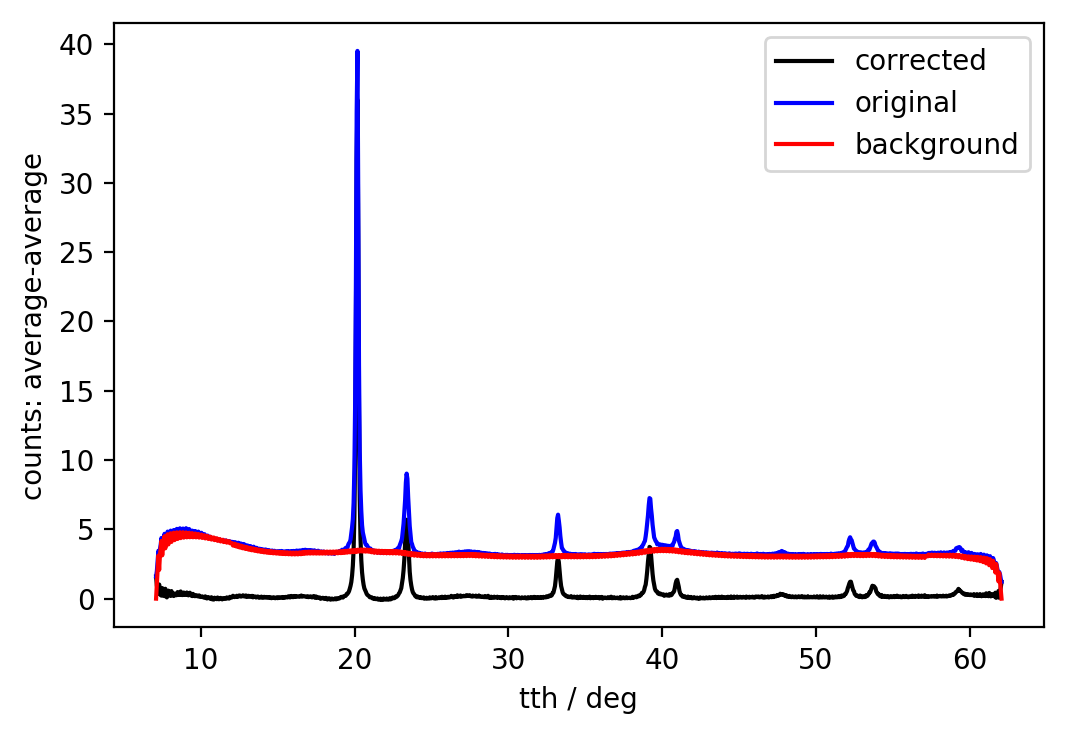

In [12]:
scan.subtract_background(background = 'endpoint', 
                         background_type = 'local'
                        )
ax = scan.plot_spectrum()                        # plots corrected spectrum
ax.plot(scan.spectrum[0], scan.spectrum[1], 'b') # original spectrum
ax.plot(scan.spectrum[0], scan.b1, 'r')          # the background
ax.legend(['corrected', 'original', 'background']);

## Tuning background subtraction

There are a lot of options to tune the background subtraction. See the docstrings for <b>EC_Xray.ScanImages.subtract_background()</b> and <b>EC_Xray.get_background_line()</b> for explanations. 

For example, setting lincutoff=False matches the background exactly to the end regions of each image spectrum, where there are 'cutoff aberations' due to the image only including part of an iso-tth ring. This seems to do a good job of fixing cutoff aberations when the global spectrum is made by averaging the local spectra, as shown in the following code cell.

To see if the algorithm is doing what you want it to do, you can put in an integer for the 'show' argument. This will show the calculated local background for the corresponding image. The image chosen here as an XRD peak at one of the endpoints, which the algorithm does a good job of avoiding when finding an appropriate linear background



function 'subtract_background' at your service!



function 'get_stacked_spectra' at your service!

using the already-calculated image spectra
self.spectra.shape = (251, 1101)

function 'get_stacked_spectra' finished!


not a combination giving b0. The background for each image will be calculated individually.

function 'subtract_background' finished!




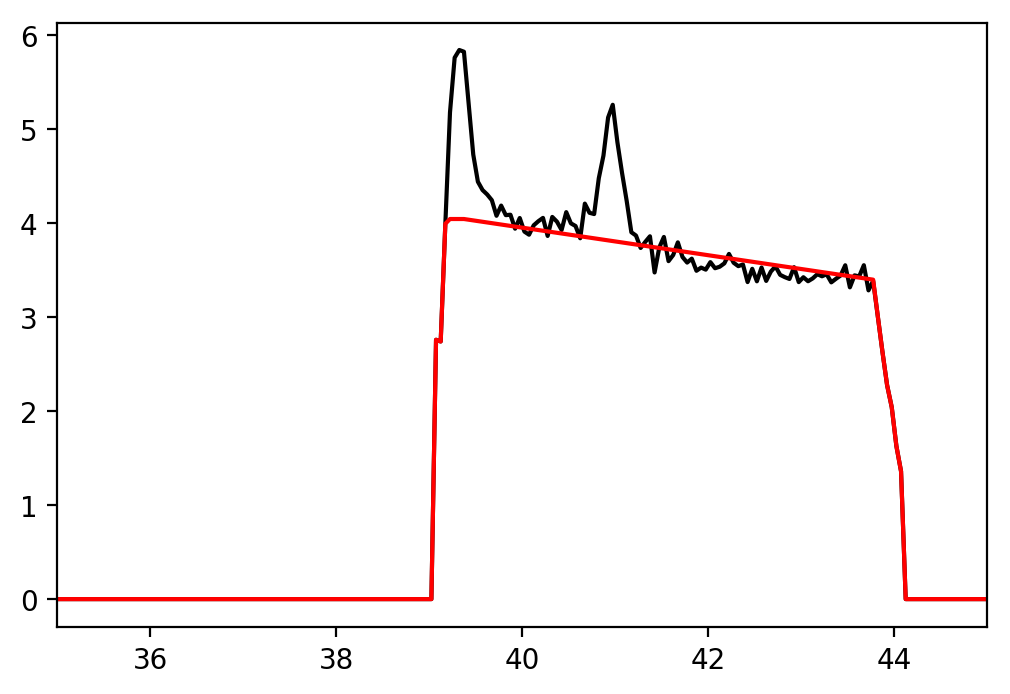

In [13]:
scan.subtract_background(lincutoff = False,  # better for cutoff aberations
                         #N_end=4, steps0=1, p1=0.2, p2=0.4,  # tunable params
                         show = 160,  # show local background for image 160
                        )
plt.gca().set_xlim([35, 45]);

## Cutoff aberation corrected

To show that the background subtraction has corrected the endpoint aberation from the image averaging step, the code here makes a zoomed-in plot of the correced spectrum coplotted with the original and the calculated background.

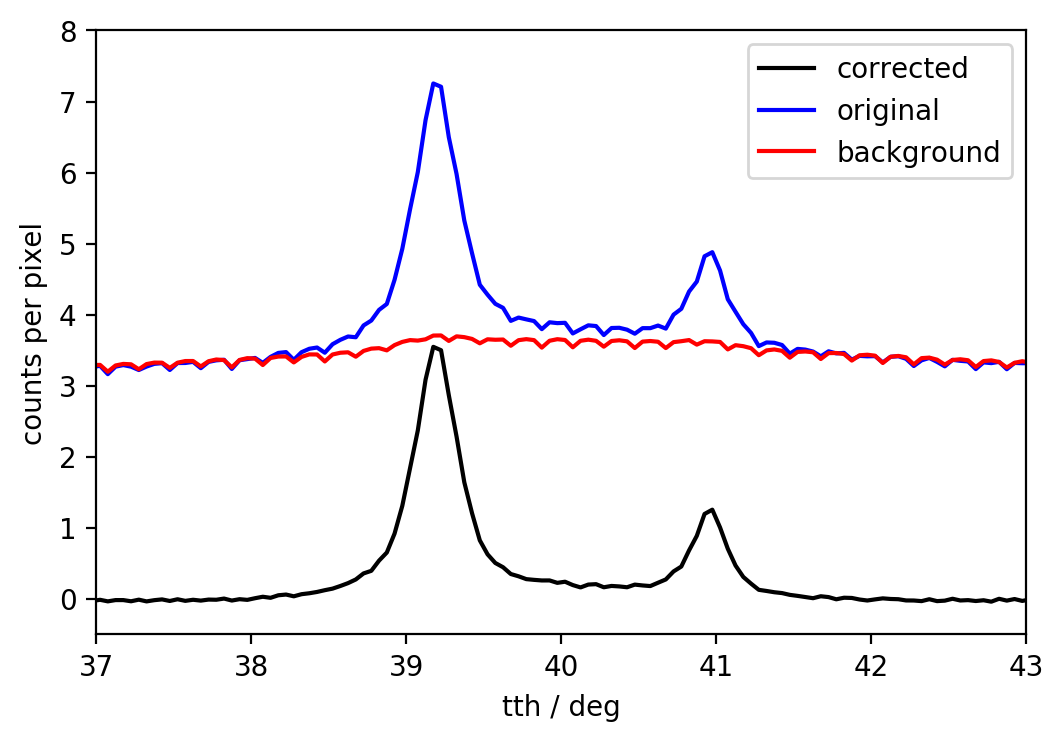

In [14]:
ax = scan.plot_spectrum()                        # corrected spectrum
ax.plot(scan.spectrum[0], scan.spectrum[1], 'b') # original spectrum
ax.plot(scan.spectrum[0], scan.b1, 'r')          # the background
ax.set_xlim([37, 43]);
ax.set_ylim([-0.5, 8]);
ax.set_ylabel('counts per pixel');
ax.legend(['corrected', 'original', 'background']);

# Dynamic displays
Lastly, there are a few ways to show all of the individual image spectra. This is especially useful if you suspect that something was changing during the tth spectrum, either due to drift beam strength or alignment, or to changes in sample surface structure.

First, you can make a movie using one of the functions,<br>
<b>EC_Xray.ScanImages.make_movie()</b>, to show the images dynamically, or <br>
<b>EC_Xray.ScanImages.make_spectrum_movie()</b> to show the spectra dynamically.<br>
This is not shown here.

Alternatively, you can plot the stacked spectra using <b>EC_Xray.ScanImages.heat_plot()</b>, as shown here.

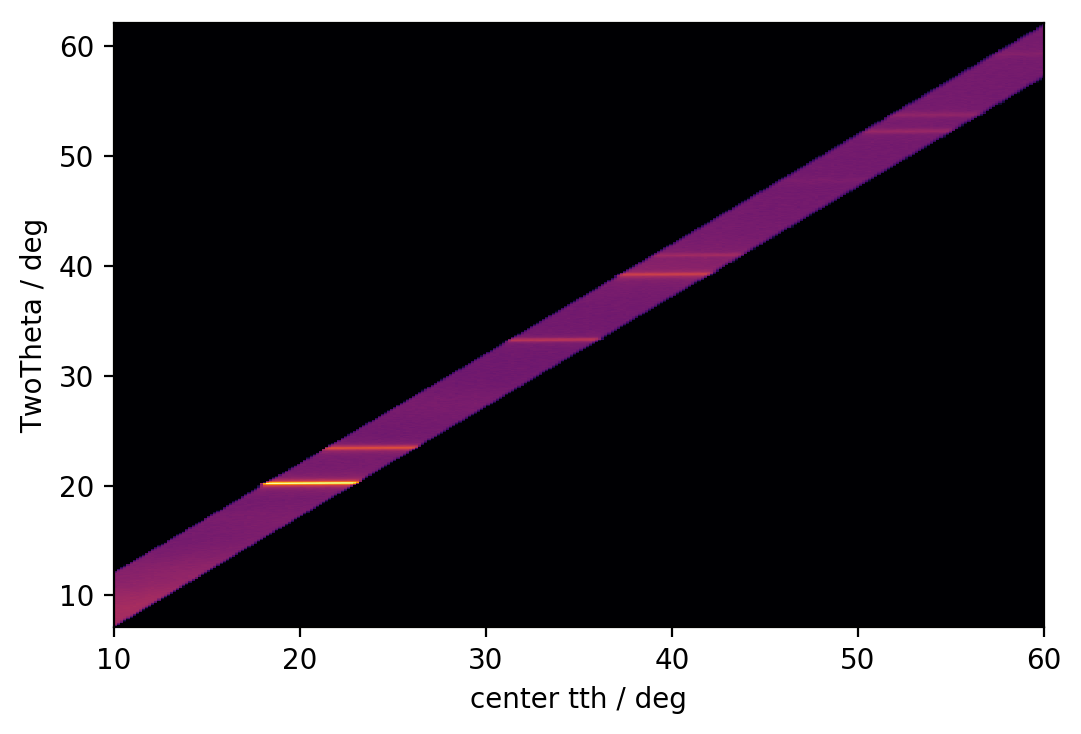

In [15]:
scan.heat_plot(logscale=True, # take ln of spectra before plotting
               bg=False,      # use the original spectra
               zrange=[0, 10] # keep points in range for color scale
              ); #returns an axis handle

# Conclusion

With the <b>EC_Xray</b> python package, you can import, analyze, and display SPEC-output XRD data with a powerful, user-friendly, object-oriented scripting interface. 

This ipython notebook has shown how to use <b>EC_Xray</b> for XRD spectra (tth scans). See the other python notebook for XRD timescans and combining synchrotron data with electrochemistry data.

# Contact

The most up-to-date version of the code will always be at https://github.com/ScottSoren/.

For colaboration or questions, contact Soren Scott at scott@fysik.dtu.dk